# Kaggle

В этом домашнем задании вам нужно будет построить модель для данных соревнования [Titanic на Kaggle](https://www.kaggle.com/c/titanic/overview), сформировать файл с предсказаниями для тестовых данных и отправить его на проверку.

В практике из урока вашим заданием было разобрать одно из самых популярных ядер для соревнования Titanic и преобразовать его таким образом, чтобы остались только преобразование данных и графики.

Соответственно, сейчас ваше ядро должно выглядеть таким образом:

In [1]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load in the train and test datasets
train = pd.read_csv('/content/drive/MyDrive/titanic/train.csv')
test = pd.read_csv('/content/drive/MyDrive/titanic/test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
full_data = [train, test]

# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] 					       = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [5]:
# Feature selection
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [ ]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


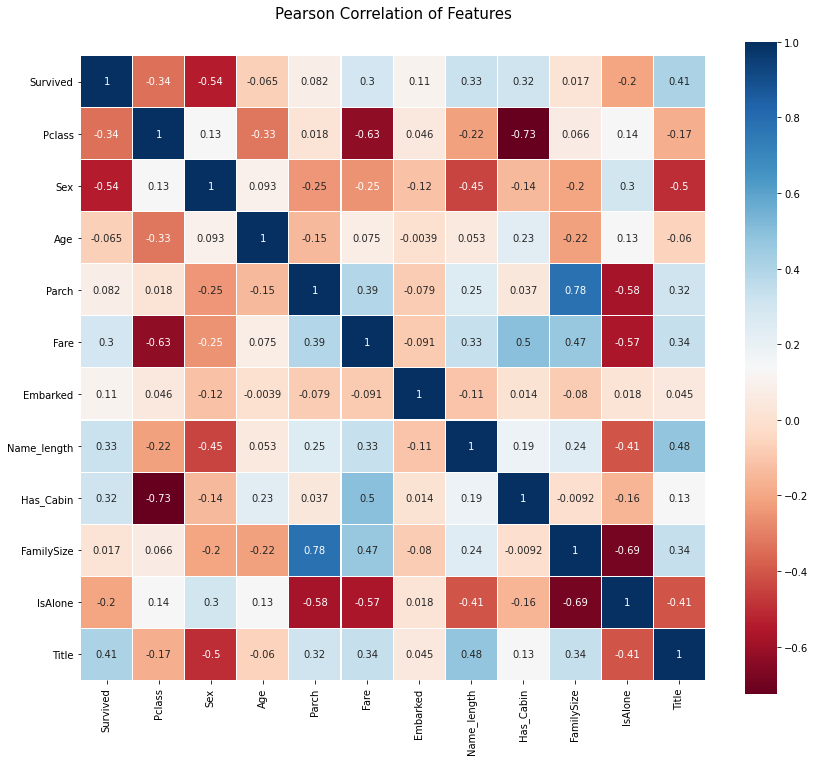

In [ ]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

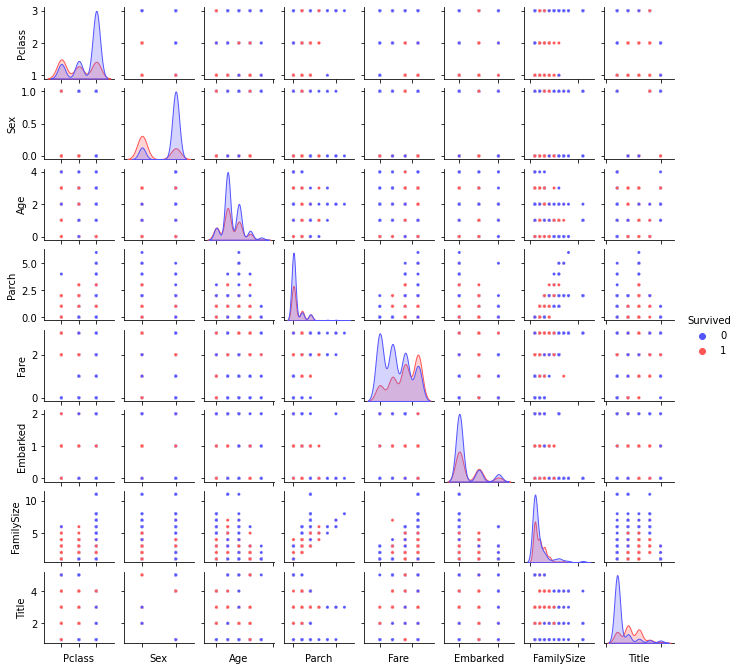

In [ ]:
g = sns.pairplot(train[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', 
                        u'Embarked', u'FamilySize', u'Title']], 
                 hue='Survived', palette = 'seismic', size=1.2, plot_kws=dict(s=10))
g.set(xticklabels=[])

Итак, у нас получились два датасета с новыми признаками. Теперь приступим к построению модели.

### Построение модели

### 1.

Воспользуйтесь вашим алгоритмом стекинга из предыдущего домашнего задания. В качестве базовых алгоритмов используйте RandomForestClassifier, SVC, GradientBoostingClassifier и LogisticRegression; в качестве мета-алгоритма - XGBoost.

Разделите данные train на тренировочную и валидационную выборки с random_state=17 и параметром разбиения test_size=.3 (в качестве целевой переменной возьмите столбец Survived, а в качестве признаков - все остальные столбцы).

Ниже приведены параметры для каждого из базовых алгоритмов, которые необходимо настроить на 5-кратной кросс-валидации с помощью GridSearchCV:

In [6]:
from sklearn.model_selection import (GridSearchCV,
                                     train_test_split,
                                     StratifiedKFold)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

# параметры базовых алгоритмов
gbc_params = {'learning_rate': np.arange(0.1, 0.6, 0.1)} # GradientBoostingClassifier

rfc_params = {'n_estimators': range(10, 100, 10), # RandomForestClassifier
              'min_samples_leaf': range(1, 5)}

svc_params = {'kernel': ['linear', 'rbf'], # SVC
              'C': np.arange(0.1, 1, 0.2)}

lr_params = {'C': np.arange(0.5, 1, 0.1)}

skf = StratifiedKFold(n_splits=5, random_state=17)

In [7]:
targets = train['Survived']

In [8]:
data = train.drop(['Survived'], axis = 1)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(data, 
                                                    targets,
                                                    test_size=0.3,
                                                    random_state=17)

### 2.
1. Определите объект GridSearchCV для всех приведенных параметров каждого алгоритма (в гиперпараметрах алгоритма при его определении, если возможно, укажите random_state=17). Параметр cv устанавливайте равным skf.

2. Обучите каждый из объектов из 1-го пункта на получившейся при разбиении тренировочной выборке. Выведите лучшее сочетание параметров для каждого из алгоритмов.

3. Для каждого обученного алгоритма получите предсказания на валидационных данных и выведите метрику качества, которая соответствует метрике оценки соревнования.

In [10]:
gbc = GradientBoostingClassifier(random_state=17)
rfc = RandomForestClassifier(random_state=17)
svc = SVC(random_state=17)
lr = LogisticRegression(random_state=17)

In [11]:
model_gbc = GridSearchCV(
    gbc, 
    gbc_params, 
    cv=skf,
    scoring='accuracy',
)

model_gbc.fit(x_train, y_train)

print('-----')
print(f'Best parameters {model_gbc.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_gbc.best_score_:.3f}'
)

-----
Best parameters {'learning_rate': 0.1}
Mean cross-validated accuracy score of the best_estimator: 0.828


In [14]:
model_rfc = GridSearchCV(
    rfc, 
    rfc_params, 
    cv=skf,
    scoring='accuracy',
)

model_rfc.fit(x_train, y_train)

print('-----')
print(f'Best parameters {model_rfc.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_rfc.best_score_:.3f}'
)

-----
Best parameters {'min_samples_leaf': 2, 'n_estimators': 20}
Mean cross-validated accuracy score of the best_estimator: 0.839


In [15]:
model_svc = GridSearchCV(
    svc, 
    svc_params, 
    cv=skf,
    scoring='accuracy',
)

model_svc.fit(x_train, y_train)

print('-----')
print(f'Best parameters {model_svc.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_svc.best_score_:.3f}'
)

-----
Best parameters {'C': 0.1, 'kernel': 'linear'}
Mean cross-validated accuracy score of the best_estimator: 0.801


In [16]:
model_lr = GridSearchCV(
    lr, 
    lr_params, 
    cv=skf,
    scoring='accuracy',
)

model_lr.fit(x_train, y_train)

print('-----')
print(f'Best parameters {model_lr.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_lr.best_score_:.3f}'
)

-----
Best parameters {'C': 0.7999999999999999}
Mean cross-validated accuracy score of the best_estimator: 0.820


### 3.
С помощью GridSearchCV и указанных ниже параметров настройте мета-алгоритм на мета-признаках (используйте 5-кратную валидацию и random_state=17 при определении алгоритма). Матрицу метапризнаков получите из предсказаний, полученных в предыдущем пункте на валидационных данных базовыми алгоритмами. Выведите лучшие параметры.

In [17]:
xgb_params = {'n_estimators': range(10, 100, 5),
              'eta': np.arange(0.1, 1., .1),
              'min_child_weight': range(1, 10, 1),
              'subsample': np.arange(0.1, 1., 0.2)}

In [18]:
xgb = XGBClassifier(random_state=17)

In [19]:
models = [model_gbc, model_rfc, model_svc, model_lr]

In [20]:
meta_mtrx = np.empty((x_train.shape[0], len(models)))        
        
for n, model in enumerate(models):
    meta_mtrx[:, n] = model.predict(x_train)

In [21]:
model_xgb = GridSearchCV(
    xgb, 
    xgb_params, 
    cv=5,
    scoring='accuracy',
)

model_xgb.fit(meta_mtrx, y_train)

print('-----')
print(f'Best parameters {model_xgb.best_params_}')
print(
    f'Mean cross-validated accuracy score of the best_estimator: ' + 
    f'{model_xgb.best_score_:.3f}'
)

-----
Best parameters {'eta': 0.1, 'min_child_weight': 8, 'n_estimators': 55, 'subsample': 0.5000000000000001}
Mean cross-validated accuracy score of the best_estimator: 0.915


### 4.
На основе алгоритма из предыдущего домашнего задания постройте стекинг (используйте 5-кратную кросс-валидацию) для всех моделей с наилучшими подобранными параметрами. В качестве тренировочных данных используйте весь датасет train.csv, а в качестве тестовых - весь датасет test.csv. Сделайте прогноз мета-алгоритма для test.csv.

In [22]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score

In [44]:
data_train = pd.read_csv('/content/drive/MyDrive/titanic/train.csv')
data_test = pd.read_csv('/content/drive/MyDrive/titanic/test.csv')

In [ ]:
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [24]:
grp = data_train.groupby(['Sex'])
data_train['Age'] = grp.Age.apply(lambda x: x.fillna(x.median()))

In [25]:
data_train.Cabin = data_train.Cabin.fillna('U')
data_train.Embarked = data_train.Embarked.fillna('U')

In [26]:
data_train['Sex'] = data_train['Sex'].replace(regex='female', value=1)
data_train['Sex'] = data_train['Sex'].replace(regex='male', value=0)

In [27]:
data_train['Embarked'] = data_train['Embarked'].replace(regex='U', value=0)
data_train['Embarked'] = data_train['Embarked'].replace(regex='S', value=1)
data_train['Embarked'] = data_train['Embarked'].replace(regex='C', value=2)
data_train['Embarked'] = data_train['Embarked'].replace(regex='Q', value=3)

In [28]:
data_train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [29]:
targets_train = data_train['Survived']
feature_train = data_train.drop(['Survived'], axis = 1)

In [30]:
grp = data_test.groupby(['Sex'])
data_test['Age'] = grp.Age.apply(lambda x: x.fillna(x.median()))

In [31]:
data_test.Cabin = data_test.Cabin.fillna('U')
data_test.Embarked = data_test.Embarked.fillna('U')

In [32]:
data_test['Sex'] = data_test['Sex'].replace(regex='female', value=1)
data_test['Sex'] = data_test['Sex'].replace(regex='male', value=0)

In [33]:
data_test['Embarked'] = data_test['Embarked'].replace(regex='U', value=0)
data_test['Embarked'] = data_test['Embarked'].replace(regex='S', value=1)
data_test['Embarked'] = data_test['Embarked'].replace(regex='C', value=2)
data_test['Embarked'] = data_test['Embarked'].replace(regex='Q', value=3)

In [34]:
data_test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [35]:
data_test['Fare'].fillna(data_test['Fare'].mean(), inplace=True)

In [40]:
def stacking(models, meta_alg, data_train, targets_train, data_test, targets_test=None, test_size=None, cv=5):

    if test_size is None:

        meta_mtrx = np.empty((data_train.shape[0], len(models)))        

   

        for n, model in enumerate(models):

            meta_mtrx[:, n] = cross_val_predict(model, data_train, targets_train, cv=cv, method='predict')

            model.fit(data_train, targets_train)

            

        meta_alg.fit(meta_mtrx, targets_train)

        

        meta_mtrx_test = np.empty((data_test.shape[0], len(models)))

        

        for n, model in enumerate(models):

            meta_mtrx_test[:, n] = model.predict(data_test)

            

        meta_predict = meta_alg.predict(meta_mtrx_test)

        

        if targets_test is not None:

            print(f'Stacking AUC: {roc_auc_score(targets_test, meta_predict)}')

    

    elif test_size > 0 and test_size < 1:

        train, valid, train_true, valid_true = train_test_split(data_train, 

                                                                targets_train,

                                                                test_size=test_size)

        

        meta_mtrx = np.empty((valid.shape[0], len(models)))

        

        for n, model in enumerate(models):

            model.fit(train, train_true)

            meta_mtrx[:, n] = model.predict(valid)

            

        meta_alg.fit(meta_mtrx, valid_true)

        

        meta_mtrx_test = np.empty((x_test.shape[0], len(models)))

        

        for n, model in enumerate(models):

            meta_mtrx_test[:, n] = model.predict(data_test)

            

        meta_predict = meta_alg.predict(meta_mtrx_test)

        

        if targets_test is not None:

            print(f'Stacking AUC: {roc_auc_score(targets_test, meta_predict)}')

        

    else:

        raise ValueError("test_size must be between 0 and 1")

        

    return meta_predict

In [38]:
predictions = stacking(models, model_xgb, feature_train, targets_train, data_test, targets_test=None, test_size=None, cv=5)

### 5.
С помощью нижеприведенной функции сформируйте файл посылки для соревнования и отправьте на Kaggle.

In [47]:
pas_id = data_test['PassengerId']

In [51]:
def write_to_submission_file(predictions, PassengerID, out_file='Submission.csv', columns=['PassengerID', 'Survived']):
    predicted_df = pd.DataFrame(np.array([PassengerId, predictions]).T, columns=columns)
    predicted_df.to_csv(out_file, index=False)

In [52]:
write_to_submission_file(predictions, pas_id)

### 6.
Каков результат score, полученного на соревновании?

Ваш ответ: 0.76076